# Titanic Survivor Dataset

This is my first ML project from Kaggle. The dataset have various information about pepole who survived or died from the tragedy. Using this data, I will build a model based on which I can predict the probability of other people's survival using their features like sex, age, fare, etc. This is a classification problem. 

# 0. Import Libraries

In [1]:
# Imports
import pandas as pd
from pandas import Series, DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# ignore Deprecation Warning
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning,RuntimeWarning) 
warnings.filterwarnings("ignore") 

# 1. Load and Check Data
Load data and pre-process to feed into ML. 


### 1.1 Load data

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Some quick inspections
print(train_df.shape, test_df.shape, '\n', train_df.columns.values, '\n', test_df.columns.values)

(891, 12) (418, 11) 
 ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked'] 
 ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Only "Age", "Cabin", "Embarked", "Fare" have null values.

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1.2 Outlier Detection
- Outliers distort the picture of the data we obtain using descriptive statitics and data visualization. When our goal is to understand the data, it is often worthwhile to disregard outliers.
- Outliers play havoc with many machine learning algorithms and statistical models. When our goal is to predict, our models are often improved by ignoring outliers.
- Outliers can be exactly what we want to learn about, especially for tasks like anomaly detection.
- Note that the variable must be continuous, not categorical, for any of these functions to make sense.

Here we use the Modified Z-score method & the IQR Method

In [5]:
def outliers_modified_z_score(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the modified z-score Method
    """
    threshold = 3.5
    outlier_indices = []
    for col in features:
        median_y = np.median(dataframe[col])
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in dataframe[col]])
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in dataframe[col]]
        outlier_list_col = dataframe[np.abs(modified_z_scores) > threshold].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers  

In [6]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop_1 = outliers_modified_z_score(train_df,2,["Age","SibSp","Parch","Fare"])

In [7]:
train_df[["Age","SibSp","Parch","Fare"]].loc[Outliers_to_drop_1] # Show the outliers rows

,Age,SibSp,Parch,Fare
27,19.00,3,2,263.0000
88,23.00,3,2,263.0000
159,NaN,8,2,69.5500
180,NaN,8,2,69.5500
201,NaN,8,2,69.5500
248,37.00,1,1,52.5542
262,52.00,1,1,79.6500
297,2.00,1,2,151.5500
305,0.92,1,2,151.5500
311,18.00,2,2,262.3750


In [8]:
def outliers_iqr(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    for col in features:
        # 1st quartile (25%) & # 3rd quartile (75%)
        quartile_1, quartile_3 = np.percentile(dataframe[col], [25,75])
        #quartile_3 = np.percentile(dataframe[col], 75)
      
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   

In [9]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = outliers_iqr(train_df,2, ["Age","SibSp","Parch","Fare"])

In [10]:
train_df[["Age","SibSp","Parch","Fare"]].loc[Outliers_to_drop] # Show the outliers rows

,Age,SibSp,Parch,Fare
27,19.0,3,2,263.00
88,23.0,3,2,263.00
159,NaN,8,2,69.55
180,NaN,8,2,69.55
201,NaN,8,2,69.55
324,NaN,8,2,69.55
341,24.0,3,2,263.00
792,NaN,8,2,69.55
846,NaN,8,2,69.55
863,NaN,8,2,69.55


We detect 10 outliers. The 28, 89 and 342 passenger have an high 
Ticket Fare

The 7 others have very high values of SibSP.

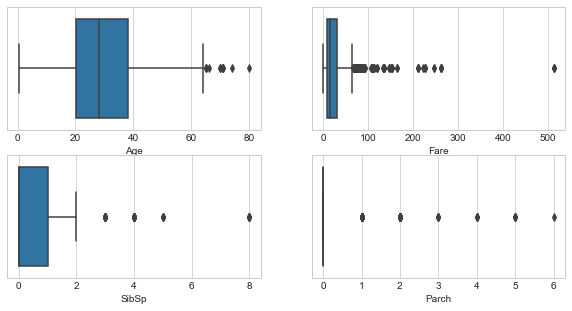

In [11]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2, sharex=False, figsize=(10,5))
sns.boxplot('Age', data=train_df, ax=axis1)
sns.boxplot('Fare',data=train_df, ax=axis2)
sns.boxplot('SibSp', data=train_df, ax=axis3)
sns.boxplot('Parch',data=train_df)


In [ ]:
# Drop outliers
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 1.3 Join training and testing dataset

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
df = train_df.append(test_df, ignore_index=True)

#train_len = len(train)
#dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### 1.4 Check for null and missing values

In [ ]:
# Fill empty and NaNs values with NaN
df.isnull().sum()

Age and Cabin features have significant amount of missing values.

Survived missing values correspond to the testing dataset (Survived column doesn't exist in test set)

# 2. Feature Analysis
Missing values will be filled. Catagorital feastures will be transformed to numberical values.

## 2.1 Numerical Values

### 2.1.1 Correlation between numberical values
Look at the Correlation matrix between numerical values (SibSp, Parch, Age and Fare)

In [ ]:
cm_df = sns.heatmap(train_df[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Only Fare seems to have a significant correlation with the survival probility (0.26). 
These pairs seem to be correlated too: 
- SibSp vs Parch (0.41)
- Fare vs Parch (0.22)
- SibSp vs Age (-0.31)

Next, I will look at each feature. 

# Parch & SibSp
 

In [ ]:
# Explore SibSp feature vs Survived
#fig, (axis1, axis2) = plt.subplots(1,2, sharex=False, figsize=(10,3))
sns.factorplot(x="SibSp",y="Survived",data=df)
#axis1.set_ylabels("survival probability")
sns.factorplot(x="Parch",y="Survived",data=df)

Passengers with more families have lower probability to survive.
- 
- There is a clear devision in the survival of passengers with 3 parents/children
Instead of having 2 columns, Parch and SibSp, we can have only one column representing if the passenger had any families aboard.

In [ ]:
df['Family'] = df['Parch'] + df['SibSp']+1
# inspect the correlation between Family and Survived
df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

In [ ]:
g=sns.factorplot(x="Family",y="Survived",data=df)
g.set_ylabels('Survival Rate')

In [ ]:
# the number of family members
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Family', data=df, ax=axis1)

# average of survived for those who had/didn't have any families
family_perc = df[['Family','Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot(x='Family',y='Survived',data=family_perc, ax=axis2)
#axis1.set_xticklabels(['With Family','Alone'],rotation=0)

In [ ]:
# inspect the family size
df['Family'].value_counts()

The survivial rate increases with the family size till Family>=5. However, the number of family with >=5 members is only 57. Besides, peole with big families (>=5) have a low survival rate too. Thereby, I will combine the data with Family>4 into one category, Family=5 

In [ ]:
df.Family = df.Family.map(lambda x: 5 if x>4 else x)
df[['Family','Survived']].groupby(['Family'], as_index=False).mean()

In [ ]:
# the number of family members
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Family', data=df, ax=axis1)

# average of survived for those who had/didn't have any families
family_perc = df[['Family','Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot(x='Family',y='Survived',data=family_perc, ax=axis2)
#axis1.set_xticklabels(['With Family','Alone'],rotation=0)

In [ ]:
# convert to indicator values 
df = pd.get_dummies(df, columns=['Family'], prefix='Fsize')

In [ ]:
df.head()

In [ ]:
# Drop "Parch" & "SibSp"
#df = df.drop(['Parch','SibSp'], axis=1)
#df = df.drop(['Parch','SibSp'], axis=1)

### Age

In [ ]:
df.Age.isnull().sum()

There are 263 missing values in Age. This can probably be inferred from other feasures, e.g., Title, Fare, SibSp, Parch, etc.

In [ ]:
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(df, hue = 'Survived', aspect=4)
#facet.map(sns.distplot, 'Age')
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()


# Averge survived passeangers by age
fig, axis1 = plt.subplots(1, 1, figsize=(18,4))
average_age = df[['Age','Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

- Age distribution seems to be a skewed gaussian distribution. 
- The distributions for survived and not survived people are different. The peak age for survived people is ~ 30, while the one for not survived people is ~ 25. 
- There are more people with age < 10 (children) survived, while fewer people with age > 60 survived. 
- As this feature is correlated with the survival rate, I will fill in the missing values. I will look at the most correalted features with Age (SibSp, Pclass, Parch and Sex). 


### Fare

In [ ]:
# check if there is any NAN
df.Fare.isnull().sum(axis=0)

Only one missing Fare value. I will fill it with the median value. 

In [ ]:
print(df.Ticket[df.Fare.isnull()],'\n', df.Pclass[df.Fare.isnull()], '\n', df.Embarked[df.Fare.isnull()], '\n', df.Cabin[df.Fare.isnull()])

There is no corresponding value for Cabin, so only look at the relation between Fare and the other three feasures

In [ ]:
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

In [ ]:
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(df, hue = 'Survived', aspect=4)
#facet.map(sns.distplot, 'Age')
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, df['Fare'].max()))
facet.add_legend()
facet.set_ylabels('Sruvival Rate')

In [ ]:
print(df["Fare"].skew())

As we can see the Fare distributions are very right-skewed for both Survived and not Survived. The skewness may cause overweight of the high-end values in the model. Thereby, i will log transform it to reduce the skewness

In [ ]:
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

In [ ]:
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(df, hue = 'Survived', aspect=4)
facet.map(sns.distplot, 'Fare')
facet.set(xlim=(0, df['Fare'].max()))
facet.add_legend()

In [ ]:
print(df["Fare"].skew())

In [ ]:
df.Fare.head()

In [ ]:
# bin Fare into five intervals with equal amount of people
# df['Fare_bin'] = pd.qcut(df.Fare,5,labels=[1,2,3,4,5]).astype(int)

# inspect the correlation between Fare-bin and Survived
#df[['Fare_bin', 'Survived']].groupby(['Fare_bin'], as_index=False).mean()

In [ ]:
#df[['Fare_bin','Survived']].groupby(['Fare_bin'],as_index=False).mean().plot.scatter('Fare_bin','Survived')
            

Now the correlation between Fare and Survived is clear after the binning

### 2.2 Categorical Values

### Cabin

In [ ]:
# check if there is any NAN
df.Cabin.isnull().sum(axis=0)

This is highly imcomplete. There are two choices: (1)map the missing ones to a new category "unknown" (2) drop this feasure. 

In [ ]:
df.Cabin.head()

In [ ]:
df.Cabin[df.Cabin.notnull()].head()

The first letter of the cabin probably indicates the Desk, Thereby I  chose to keep this information only, since it indicates the probable location of the passenger in the Titanic.

In [ ]:
# Replace the Cabin number by the type of cabin 'X' if not
df.Cabin = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df.Cabin ])

In [ ]:
df.Cabin.head()

In [ ]:
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(df["Cabin"], ax=axis1, order=['A','B','C','D','E','F','G','T','X'])
sns.factorplot(y="Survived",x="Cabin", data=df,kind="bar", ax=axis2, order=['A','B','C','D','E','F','G','T','X'])

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B, C, D, E and F.

In [ ]:
df = pd.get_dummies(df, columns = ["Cabin"],prefix="Cabin")

### Embarked

In [ ]:
# check if there is any NAN
df.Embarked.isnull().sum(axis=0)

In [ ]:
df['Embarked'].value_counts()

In [ ]:
df = df.fillna({'Embarked':'S'})

"S" is the most occurred value. Thereby we will fill nulll values with "S"

In [ ]:
# inspect the correlation between Embarked and Survived as well as some other features

#sns.factorplot('Embarked', 'Survived', data=df, size=2, aspect=2)

fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(15,2))
sns.countplot(x='Embarked', data=df, ax=axis1)
sns.countplot(x='Survived', hue='Embarked',data=df, order=[1,0],ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = df[['Embarked','Survived']].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived',data=embark_perc, order=['S','C','Q'],ax=axis3)

- The most passengers embarked from 'S' station, followed by 'C' and 'Q'
- The trend remains when we grouped them by Survived or not. 
- Survived people are mostly embarked from 'C'. 
My guess is that the Fare for "C" is also higher and they are mostly from first class. 

In [ ]:
fare_perc = df[['Embarked','Fare']].groupby(['Embarked'],as_index=False).median()
sns.barplot(x='Embarked', y='Fare',data=fare_perc, order=['S','C','Q'])

sns.factorplot("Pclass", col="Embarked",  data=df,
                   size=6, kind="count", palette="muted")


Indeed, the most passengers from "S" and "Q" are in the 3rd class, whereas the most passengers from "C" are in the first class. The mean Fare price for "C" is also the highest. 

In [ ]:
#df[['Embarked', 'Survived','Pclass','Fare', 'Age', 'Sex']].groupby(['Embarked'], as_index=False).mean()
df[['Embarked', 'Survived','Pclass','Fare', 'Age']].groupby(['Embarked'], as_index=False).mean()

The survival rate changes with Embarked but it may actually due to other feasures, e.g., Pclass, Fare and Age. 

In [ ]:
#  Remove 'S' dummy variable, and leave 'C' and 'Q', since they seem to have a good rate for survival. 
embark_dummies_df = pd.get_dummies(train_df['Embarked'])
embark_dummies_df.drop('S', axis=1, inplace=True)

df = df.join(embark_dummies_df)

#df.drop(['Embarked'], axis=1,inplace=True)

In [ ]:
df.head()

### Name

In [ ]:
df.Name.head()

In [ ]:
df['Title'] = df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())
# inspect the amount of people for each title
df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip()).value_counts()

The main titles are: "Mr","Miss","Mrs" & "Master". Some of the others can be merged into one of the four categories. The rest will be merged into "Others"

In [ ]:
df['Title'] = df['Title'].replace(['Mme','Lady','Ms','Mille','Miss'], 'Mrs')
df.Title.loc[ (df.Title != 'Master') & (df.Title != 'Mr') & (df.Title != 'Mrs')] = 'Others'
# inspect the correlation between Title and Survived
#df[['Title','Survived']].groupby(['Title'], as_index=False).mean()

In [ ]:
# inspect the amount of people for each title
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Title', data=df,ax=axis1)
#sns.factorplot('Family', data=train_df, kind='count', ax=axis2)

# average of survived for those who had/didn't have any families
family_perc = df[['Title','Survived']].groupby(['Title'], as_index=False).mean()
sns.barplot(x='Title',y='Survived',data=family_perc, ax=axis2)
#axis1.set_xticklabels(['With Family','Alone'],rotation=0)

"Women and childen first"?

In [ ]:
df['Title'].value_counts()

Now we can use dummy variables for these titles and drop the orginal columns. 

In [ ]:
df = pd.concat([df, pd.get_dummies(df['Title'])], axis=1).drop(labels=['Name'], axis=1)

Title can be indicative of the Age. 

In [ ]:
df.head()

In [ ]:
# inspect the amount of people for each title
sns.factorplot(x='Title',y='Survived',hue='Sex', data=df, kind='bar')

In [ ]:
sns.factorplot(x='Title',col='Survived',hue='Sex', data=df, kind='count')

Check the gender in "Others"

### Pclass

In [ ]:
# check if there are any null values
df['Pclass'].isnull().sum(axis=0)

In [ ]:
# inspect the corrleatoin between Pclass and survived
#df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()
g= sns.factorplot('Pclass','Survived', order=[1,2,3],data=train_df,size=3)
g.set_ylabels('Survival Rate')

We can see that a higher class has a higher survival rate. 

In [ ]:
# inspect the corrleatoin between Pclass and survived by Sex
g= sns.factorplot('Pclass','Survived', hue ='Sex', order=[1,2,3],data=train_df, kind = 'bar', size=3)
g.set_ylabels('Survival Rate')

The trend remains when adding in the gender infromation

Create dummy variable for Pclass & drop the 3 rd class as it has the lowest average of survived passengers

In [ ]:
pclass_dummies_df = pd.get_dummies(df['Pclass'])
pclass_dummies_df.columns = ['Class1','Class2','Class3']
#pclass_dummies_df.drop(['Class3'], axis=1, inplace=True)

#df.drop(['Pclass'], axis=1, inplace=True)

df = df.join(pclass_dummies_df)



In [ ]:
# Drop useless columns
#train_df = train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
#test_df = test_df.drop(['Name','Ticket'], axis=1)

In [ ]:
# Fill in NaN values of Age with the mean value



### Sex

As we see, children (age<16) on aboard eem to have a high chances for survival. so we can classify passengers as males, females, and child

In [ ]:
df.Sex.isnull().sum(axis=0)

In [ ]:
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

In [ ]:
# map the two genders to 0 and 1
df.Sex = df.Sex.map({'male':0, 'female':1})

In [ ]:
# inspect the correlation between Sex and Survived 
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Sex', data=df, order=[1,0],ax=axis1)

sex_perc = df[['Sex','Survived']].groupby(['Sex'], as_index=False).mean()
sns.barplot(x='Sex',y='Survived',data=sex_perc, ax=axis2)

In [ ]:
'''
def get_person(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex

df['Person'] = df[['Age','Sex']].apply(get_person, axis=1)

df['Person'].head()

# No need to use sex col since we created person col
df.drop(['Sex'],axis=1,inplace=True)


# Create dummy variables for Person column, & drop male as it has the lowest average of surved passengers
person_dummies_df = pd.get_dummies(df['Person'])
#person_dummies_df.columns = ['Child','Female','Male']
#person_dummies_df.drop(['Male'],axis=1, inplace=True)

#df = df.join(person_dummies_df)

# map the two genders to 0 and 1
df.Sex = df.Sex.map({'male':0, 'female':1})

'''


### Ticket

In [ ]:
df.Ticket.isnull().sum(axis=0)

In [ ]:
df.Ticket.head(10)

It seems like there are two types of tickects: (1)number only (2) letter+number. Tickets start with letters probably represent some special classes, and the first digit of the numbers may prepresent the class. 

In [ ]:
df.Ticket = df.Ticket.map(lambda x:x[0])
df['Ticket'].value_counts()

In [ ]:
# inspect the amount of people for each type of tickets
#df['Ticket'].value_counts()
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Ticket', data=df, ax=axis1)
# inspect the correlatin between Ticket and Survived
#df[['Ticket','Survived']].groupby(['Ticket'], as_index=False).mean()
sex_perc = df[['Ticket','Survived']].groupby(['Ticket'], as_index=False).mean()
sns.barplot(x='Ticket',y='Survived',data=sex_perc, ax=axis2)

We can see here that the majority of the tickest are "1","2","3", and their survival rates are "1">"2">"3". The rates for others are low, except for "9"(2),"C"(77),"F"(13),"P"(98), and "S"(98). "9""F" are very small samples. The high rates here are probably from Pclass or Fase. Let's check. 

In [ ]:
#df[['Ticket', 'Fare']].groupby(['Ticket'], as_index=False).mean()
#df[['Ticket', 'Pclass']].groupby(['Ticket'], as_index=False).mean()

fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))

fare_perc = df[['Ticket','Fare']].groupby(['Ticket'], as_index=False).mean()
sns.barplot(x='Ticket',y='Fare',data=fare_perc, ax=axis1)
Pclass_perc = df[['Ticket','Pclass']].groupby(['Ticket'], as_index=False).mean()
sns.barplot(x='Ticket',y='Pclass',data=Pclass_perc, ax=axis2)

In [ ]:
### Drop useless features & check the header.
df.drop(labels=['PassengerId'], axis=1, iinplace=True)

In [ ]:
df.head()

# 4. Modeling and Prediction

Now we can drop useless features and split the data into training and testing sets. Then i will use various models and make predictions.

In [ ]:
df.head()

In [ ]:
df.drop(['PassengerId','Parch','SibSp','Title'], axis=1, inplace=True)

X_train = df[0:891].drop(['Survived'], axis=1).values
Y_train = df[0:891]['Survived'].values
X_test  = df[891:].drop(['Survived'], axis=1).values


In [ ]:
# define training and testing sets
#X_train = train_df.drop('Survived', axis=1)
#Y_train = train_df['Survived']
#X_test = test_df.drop('PassengerId', axis=1).copy()
#X_train

### 4.1 Logistic Regression

In [ ]:
# Logistic Regress
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
#logreg.score(X_train, Y_train)
logreg.score(X_train, Y_train)


### 4.2 SVM

In [ ]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
svc.score(X_train,Y_train)

### 4.3 Random Forest

### 4.3.1 Training

In [ ]:
# Ramdom Forests
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
print('Train accuracy with RF:', rf.score(X_train,Y_train))
print('Train accuracy with RF:', rf.score(X_test,Y_test))

### 4.3.2 Specifying the parameter grid

RF has many parameters that we can tune. However, manually tuning them is very time-consuming. Thereby we use cross validation to search through these parameters to come up with best ones for our data

### 4.3.3 Cross Validation

### 4.3.4 Results

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
knn.score(X_train, Y_train)

In [ ]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
gaussian.score(X_train, Y_train)

In [ ]:
# get Correlation Coefficient for each feasure using Logistic Regression
coeff_df = DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df['Coefficient Estimate'] = pd.Series(logreg.coef_[0])
coeff_df

# 5 Gernerating Submission File

In [ ]:
submission = pd.DataFrame({ "PassengerId": test_df["PassengerId"], "Survived": Y_pred})
submission.to_csv('titanic.csv', index=False)